In [1]:
import cirq
import matplotlib.pyplot as plt
import sinter
import stim
from stimcirq import cirq_circuit_to_stim_circuit, stim_circuit_to_cirq_circuit

from tqec.constructions.qubit import ScalableQubitSquare
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    DepolarizingNoiseOnIdlingQubit,
    MultiQubitDepolarizingNoiseAfterMultiQubitGate,
    XNoiseAfterReset,
    XNoiseBeforeMeasurement,
)
from tqec.plaquette.library import (
    XXXXPlaquette,
    ZZZZPlaquette,
)
from tqec.plaquette.library.xx import XXPlaquette
from tqec.plaquette.library.zz import ZZPlaquette
from tqec.detectors.gate import ObservableGate, RelativeMeasurement
from tqec.position import Shape2D

In [2]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        XNoiseBeforeMeasurement(noise_level),
        MultiQubitDepolarizingNoiseAfterMultiQubitGate(noise_level),
        XNoiseAfterReset(noise_level),
        DepolarizingNoiseOnIdlingQubit(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

In [3]:
def generate_cirq_circuit(dimension: int, repetitions: int) -> cirq.Circuit:
    template = ScalableQubitSquare(dimension)
    plaquettes = [
        ZZPlaquette(PlaquetteOrientation.UP),
        XXPlaquette(
            PlaquetteOrientation.LEFT, include_initial_and_final_detectors=False
        ),
        ZZZZPlaquette(),
        XXXXPlaquette(include_initial_and_final_detectors=False),
        XXPlaquette(
            PlaquetteOrientation.RIGHT, include_initial_and_final_detectors=False
        ),
        ZZPlaquette(PlaquetteOrientation.DOWN),
    ]

    def make_repeated_layer(circuit: cirq.Circuit) -> cirq.Circuit:
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    layer_modificators = {1: make_repeated_layer}

    circuit = cirq.Circuit()
    for layer_index in range(3):
        layer_circuit = generate_circuit(template, plaquettes, layer_index=layer_index)
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # Compute the qubits that should be measured to get the Z logical operator.
    plaquette_shape: Shape2D = plaquettes[0].shape
    assert all(
        p.shape == plaquette_shape for p in plaquettes
    ), "All plaquettes should have exactly the same shape for the moment."
    vertical_center_index: int = (1 + dimension // 2) * (plaquette_shape.y - 1)
    origin = cirq.GridQubit(vertical_center_index, plaquette_shape.x - 1)
    circuit.append(
        [
            ObservableGate(
                origin,
                [
                    RelativeMeasurement(
                        cirq.GridQubit(0, i * (plaquette_shape.x - 1)), -1
                    )
                    for i in range(dimension + 1)
                ],
            ).on(origin)
        ]
    )

    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

In [4]:
def generate_stim_circuit(
    dimension: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    circuit_with_detectors = generate_cirq_circuit(dimension, repetitions)
    noisy_circuit = to_noisy_circuit(circuit_with_detectors, noise_level)

    return cirq_circuit_to_stim_circuit(noisy_circuit)

In [14]:
cirq_circuit = generate_cirq_circuit(2, 0)
stim_circuit = generate_stim_circuit(10, 0.001, 30)

stim_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 3) 0
    QUBIT_COORDS(1, 7) 1
    QUBIT_COORDS(1, 11) 2
    QUBIT_COORDS(1, 15) 3
    QUBIT_COORDS(1, 19) 4
    QUBIT_COORDS(2, 2) 5
    QUBIT_COORDS(2, 4) 6
    QUBIT_COORDS(2, 6) 7
    QUBIT_COORDS(2, 8) 8
    QUBIT_COORDS(2, 10) 9
    QUBIT_COORDS(2, 12) 10
    QUBIT_COORDS(2, 14) 11
    QUBIT_COORDS(2, 16) 12
    QUBIT_COORDS(2, 18) 13
    QUBIT_COORDS(2, 20) 14
    QUBIT_COORDS(2, 22) 15
    QUBIT_COORDS(3, 3) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(3, 7) 18
    QUBIT_COORDS(3, 9) 19
    QUBIT_COORDS(3, 11) 20
    QUBIT_COORDS(3, 13) 21
    QUBIT_COORDS(3, 15) 22
    QUBIT_COORDS(3, 17) 23
    QUBIT_COORDS(3, 19) 24
    QUBIT_COORDS(3, 21) 25
    QUBIT_COORDS(3, 23) 26
    QUBIT_COORDS(4, 2) 27
    QUBIT_COORDS(4, 4) 28
    QUBIT_COORDS(4, 6) 29
    QUBIT_COORDS(4, 8) 30
    QUBIT_COORDS(4, 10) 31
    QUBIT_COORDS(4, 12) 32
    QUBIT_COORDS(4, 14) 33
    QUBIT_COORDS(4, 16) 34
    QUBIT_COORDS(4, 18) 35
    QUBIT_COORDS(4, 20) 36
    QUBI

In [15]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=30,
    distance=11,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01,
)
surface_code_circuit_cirq = stim_circuit_to_cirq_circuit(surface_code_circuit)

surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(6, 0) 6
    QUBIT_COORDS(7, 1) 7
    QUBIT_COORDS(9, 1) 9
    QUBIT_COORDS(10, 0) 10
    QUBIT_COORDS(11, 1) 11
    QUBIT_COORDS(13, 1) 13
    QUBIT_COORDS(14, 0) 14
    QUBIT_COORDS(15, 1) 15
    QUBIT_COORDS(17, 1) 17
    QUBIT_COORDS(18, 0) 18
    QUBIT_COORDS(19, 1) 19
    QUBIT_COORDS(21, 1) 21
    QUBIT_COORDS(1, 3) 24
    QUBIT_COORDS(2, 2) 25
    QUBIT_COORDS(3, 3) 26
    QUBIT_COORDS(4, 2) 27
    QUBIT_COORDS(5, 3) 28
    QUBIT_COORDS(6, 2) 29
    QUBIT_COORDS(7, 3) 30
    QUBIT_COORDS(8, 2) 31
    QUBIT_COORDS(9, 3) 32
    QUBIT_COORDS(10, 2) 33
    QUBIT_COORDS(11, 3) 34
    QUBIT_COORDS(12, 2) 35
    QUBIT_COORDS(13, 3) 36
    QUBIT_COORDS(14, 2) 37
    QUBIT_COORDS(15, 3) 38
    QUBIT_COORDS(16, 2) 39
    QUBIT_COORDS(17, 3) 40
    QUBIT_COORDS(18, 2) 41
    QUBIT_COORDS(19, 3) 42
    QUBIT_COORDS(20, 2) 43
    QUBIT_COORDS(21, 3) 44
    QUB

In [12]:
surface_code_tasks = [
    sinter.Task(
        circuit=generate_stim_circuit(d - 1, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.008, 0.009, 0.01, 0.011]
]

collected_surface_code_stats: list[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=["pymatching"],
    max_shots=100_000,
    max_errors=5_000,
    print_progress=False,
)

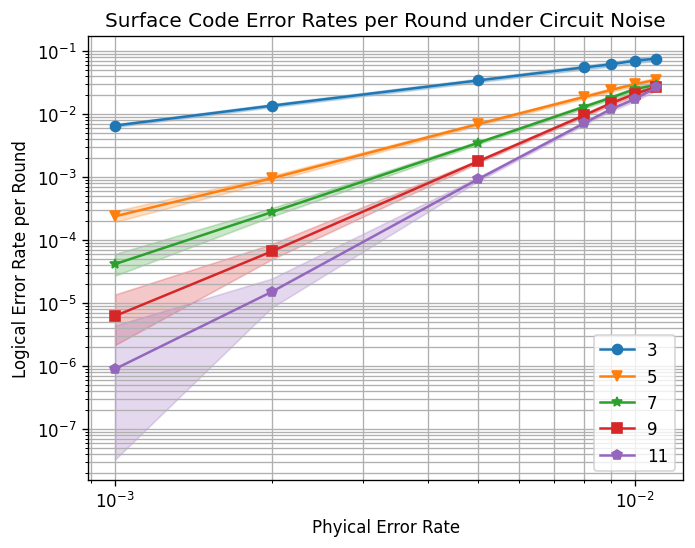

In [13]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger